# Lab 1: Localizing language in the brain
In this notebook, we'll analyze a typical experimental contrast for localizing language (or speech) processing in the brain. We'll use a general linear model (GLM) to analyze an experimental dataset contrasting sentences with a control condition of nonsense words.

In [1]:
# Import some useful Python modules
from os.path import join
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd

### Part 1: Language localizer "by hand"
In this section, we'll work through the basics of handling fMRI data and the experimental design, then run a very simple linear regression model to identify voxels that respond more strongly to sentences than the control condition. We'll code several steps of the analysis "by hand" so that you can see what's happening under the hood; for production-level analyses, analysis software will typically abstract much of the nitty-gritty (see Part 2). This "localizer" experiment for identifying language areas is intended to provide a very simple example following the approach popularized by Fedorenko and colleagues (e.g., [2010](https://doi.org/10.1152/jn.00032.2010), [2024](https://doi.org/10.1038/s41583-024-00802-4)).

For Part 1, we'll use an open dataset of $N=10$ subjects performing a classical language localizer task graciously provided by Christophe Pallier as part of the [*Nilearn*](https://nilearn.github.io/) package ([Abraham et al., 2014](https://doi.org/10.3389/fninf.2014.00014)). In this experiment, subjects covertly read either (1) meaningful sentences composed of a series words (in French) presented rapidly one-by-one at the center of the screen (labeled `language`, or (2) meaningless sequences of nonwords comprising strings of consonants presented in the same way (labeled `string`) ([Pallier, 2019](https://osf.io/k4jp8)) We'll use *Nilearn*'s `fetch_language_localizer_demo_dataset` convenience function to download the dataset. Set `data_dir` to a path on your computer where you'd like the demo data to live (otherwise, *Nilearn* will download the dataset into your home directory). It may take a couple minutes to download the dataset depending on your connection.

In [2]:
# Load in dataset using nilearn
from nilearn import datasets

# Change this path to match your local machine
data_dir = '/Users/snastase/Work/psyc599/nilearn-data'
dataset = datasets.fetch_language_localizer_demo_dataset(data_dir=data_dir)

[fetch_language_localizer_demo_dataset] Dataset found in /Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset


Have a look at what file paths are included in the `datasets` object to orient yourself.

In [3]:
# Explore dataset:
print(type(dataset))
dataset

<class 'sklearn.utils._bunch.Bunch'>


{'data_dir': '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset',
 'func': ['/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/.DS_Store',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/.bidsignore',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/CHANGES',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/README',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/access_data.py',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/dataset_description.json',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/derivatives/.DS_Store',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/derivatives/dataset_description.json',
  '/Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/derivat

Next, let's pick an examples subject (e.g., `sub-01`) for prototyping. We'll set up a couple paths so that we can more easily load in (1) the `_bold.nii.gz` file (the fMRI data), (2) the `_events.tsv` file (the experimental design), and (3) `desc-confounds_regressors.tsv` file (head motion) for this subject. We'll ignore the confound regressors for right now to keep things simple.

In [4]:
# Pick example subject, e.g., sub-01 or sub-02
subject = 'sub-01'

# Set up files for BOLD data, events, and confounds
bids_dir = join(data_dir, 'fMRI-language-localizer-demo-dataset')
deriv_dir = join(bids_dir, 'derivatives')

bold_f = join(deriv_dir, subject, 'func', f'{subject}_task-languagelocalizer_desc-preproc_bold.nii.gz')
events_f = join(bids_dir, subject, 'func', f'{subject}_task-languagelocalizer_events.tsv')
confounds_f = join(deriv_dir, subject, 'func', f'{subject}_task-languagelocalizer_desc-confounds_regressors.tsv')

Let's also establish a couple basic parameters for this experiment. There are $229~\mathrm{TRs}$ (time points) in this fMRI dataset and $\mathrm{TR} = 1.5~\mathrm{s}$. (These parameters were set by the experimenters prior to data collection and can be found in the `_bold.json` file accompanying each `_bold.nii.gz` file.)

In [5]:
# fMRI metadata for this experiment
n_trs = 229
tr = 1.5

#### Preparing the fMRI data for modeling
Use `nib.load` (from the *NiBabel* module you imported above) to load in the fMRI data for this subject (`bold_f`). Inspect the `.shape` of the BOLD image and use `assert` to check the number of TRs defined above (`n_trs`) against the BOLD image itself.

In [6]:
# Load BOLD data and check shape:
bold_img = nib.load(bold_f)
print(bold_img.shape)

# Check that number of TRs matches:
assert n_trs == bold_img.shape[-1]

(45, 53, 43, 229)


Next, use `index_img` from `nilearn.image` (you'll need to import it) to extract the first time point (TR) of the BOLD dataset. Use `plot_epi` from `nilearn.plotting` to visualize the first TR of the BOLD dataset. Note that the acronyms *blood-oxygenation-level–dependent* (BOLD), *echo-planar imaging* (EPI), and *functional magnetic resonance imaging* (fMRI) are all being used fairly interchangeably here to refer to the functional time series of fMRI data.

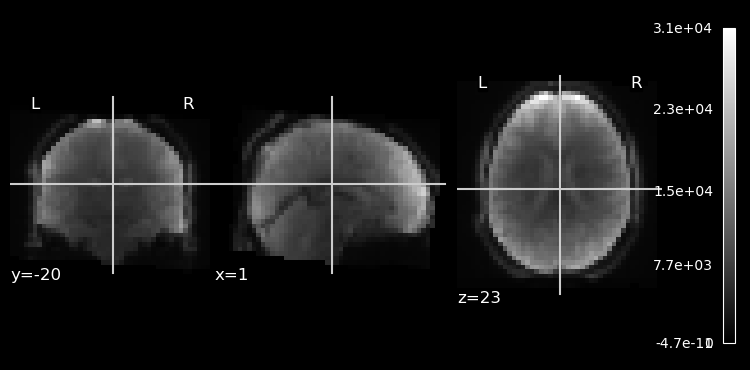

In [7]:
# Plot first time point of BOLD image:
from nilearn.image import index_img
from nilearn.plotting import plot_epi

plot_epi(index_img(bold_img, 0));

The BOLD dataset is a roughly-cubical 3-dimensional image "brick" acquired at each time point, but the brain itself is a round little blob inside that brick. This means that BOLD images also include a lot of "empty" voxels that are completely outside the brain and contain no meaningful signal (look at all those black voxels outside the edges of the brain). How can we zoom in on the brain itself? Although everybody's brain is unique in shape and size, these data have already been spatially normalized to match the widely used MNI template; that is, this subject's brain has already been standardized to a common size/shape in a common coordinate system called [MNI space](https://www.lead-dbs.org/about-the-mni-spaces/). This means we can load in a standardized "mask" for MNI space and use this mask to isolate the brain voxels in our BOLD dataset.

In [8]:
# Load in MNI template brain mask
mni_mask = datasets.load_mni152_brain_mask()
print(mni_mask.shape)

(197, 233, 189)


Note that the MNI mask appears to have many more voxels in all three dimensions than our BOLD dataset. This is because the MNI template was acquired at a much higher resolution ($1~\mathrm{mm^3}$) than our BOLD dataset ($4.5~\mathrm{mm^3}$) (and may also be on a different "grid" overall). Use `resample_to_img` from `nilearn.image` to resample the mask (`source_img`) to the same resolution and grid as our BOLD data (`target_img`). Make sure to use nearest-neighbor interpolation (`interpolation='nearest'`) when you resample a mask (or atlas) image to avoid introducing non-integer values. Check (e.g., using `assert`) that the mask shape now matches the spatial dimensions of the BOLD dataset. In my code, I call this resampled MNI mask `mni_mask_r`.

In [9]:
# Resample MNI mask image to match BOLD image:
from nilearn.image import resample_to_img

mni_mask_r = resample_to_img(mni_mask, bold_img, interpolation='nearest')
print(mni_mask_r.shape)
assert mni_mask_r.shape == bold_img.shape[:3]

(45, 53, 43)


Use `plot_roi` from `nilearn.plotting` to plot the resampled MNI mask on top of (i.e., `bg_img` in `plot_roi`) the first time point of the BOLD dataset—to prove to yourself that they're reasonably well-aligned.

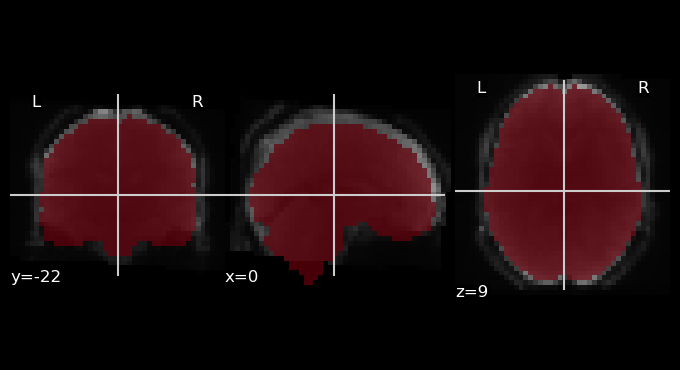

In [10]:
# Plot mask on top of first TR of BOLD image:
from nilearn.plotting import plot_roi

plot_roi(mni_mask_r, bg_img=index_img(bold_img, 0),
         cmap='Reds', vmin=0, vmax=1, colorbar=False);

To actually apply the mask to the BOLD data, we'll use `NiftiMasker` from `nilearn.maskers`. Keeping track of voxel coordinates for going back and forth between an original image and the masked image is pretty annoying—using `NiftiMasker` here will save us a lot of pain and suffering. We'll first initalize a `masker` object using the resampled MNI mask we previously created. (I called my resampled mask `mni_mask_r`, but you'll need to change the input to match your own variable name.)

In [11]:
# Creater a "masker" based on the resampled mask
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(mask_img=mni_mask_r)

Now, use the `masker`'s `.fit_transform` method to apply the mask to your BOLD dataset. Have a look at the new shape/axes of the dataset. How many voxels do we have left after masking for only brain voxels?

In [12]:
# Mask the BOLD data using the MNI mask:
# (you can safely ignore the warning here)
bold_masked = masker.fit_transform(bold_img)
print(bold_masked.shape)

/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_47757/2909987310.py:3: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  bold_masked = masker.fit_transform(bold_img)


(229, 20657)


Finally, use `zscore` from `scipy.stats` to z-score the time series for each voxel. You'll need to use the `axis` argument in `zscore` to get this right. Name this final format of the BOLD dataset `Y`. This will be the target variable in our regression equation.

In [13]:
# Z-score voxelwise time series:
from scipy.stats import zscore

Y = zscore(bold_masked, axis=0)

#### Preparing the design matrix
Now, we'll read in the events and confounds files (tab-separated tables) as *pandas* *DataFrame*s. Have a look at these tables: the `events` table contains the onsets and durations of the two experimental conditions over the course of our subject's scan; the `confounds` table contains six (three rotation, three translation) time series capturing their head motion over the course of the scan. We'll focus on just the `events` for now.

In [14]:
# Load in events and confounds tables
events = pd.read_csv(events_f, delimiter='\t')
confounds = pd.read_csv(confounds_f, delimiter='\t')
events

,onset,duration,trial_type
0,3.516,6.806,language
1,17.707,7.004,string
2,32.011,6.805,language
3,46.306,7.206,string
4,60.604,6.804,language
5,74.908,6.804,string
6,89.208,6.808,language
7,103.508,6.806,string
8,117.804,6.806,language
9,132.108,6.809,string


We need to convert the onsets, durations, and condition labels into a design matrix with columns of $0$s and $1$s marking the occurrence of each condition for each time point. Here's a little loop to do this for you—make sure you understand what it's doing. I create a time series called `language_events` with $1$s indicating where the `language` task (meaningful sentences) is occuring (and $0$s elswhere), and a time series called `control_events` with $1$s where the `control` task (meaningless strings) is occurring (and $0$s elsewhere). Note that I'm using `np.round` to implicitly downsample the onsets and durations to the sampling rate (i.e., TR) of the fMRI data. (Production-level code will handle this in a more sophisticated way.)

In [15]:
# Start with empty time series 
language_events = np.zeros((n_trs))
control_events = np.zeros((n_trs))    

# Add 1s to mark language/control events
for event in events.itertuples():
    onset = int(np.round(event.onset / tr))
    duration = int(np.round(event.duration / tr))
    if event.trial_type == 'language':
        language_events[onset : onset + duration] = 1
    elif event.trial_type == 'string':
        control_events[onset : onset + duration] = 1

Use `plt.plot` to create line plots of the time series for the two conditions. You may want to use `plt.subplots` to create two adjacent plots with shared axes and adjust the `figsize`; e.g., for a wide figure, use `figsize=(8, 2)`. Make sure to correctly label the time axis units.

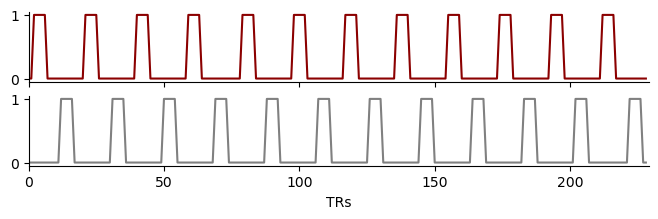

In [16]:
# Plot language and control time series:
fig, axs = plt.subplots(2, 1, figsize=(8, 2),
                        sharex=True, sharey=True)
axs[0].plot(language_events, c='darkred')
axs[1].plot(control_events, c='.5')
axs[1].set(xlabel='TRs', xlim=(0, n_trs))
sns.despine()

The above plot reflects the hypothesized "neural" activity for the two different experimental conditions—but with fMRI, we can't directly measure the temporally-precise neural activity; instead, we measure the hemodynamic response (i.e., the BOLD response), which is sluggish and smooth in time. To update our model to better reflect the BOLD signal, we will load in a predefined hemodynamic response function (HRF) ([Glover, 1999](https://doi.org/10.1006/nimg.1998.0419)). Let's visualize the HRF first, before we apply it to our regressors. Note that the HRF is matched to our TR and peaks at $\approx5~\mathrm{s}$.

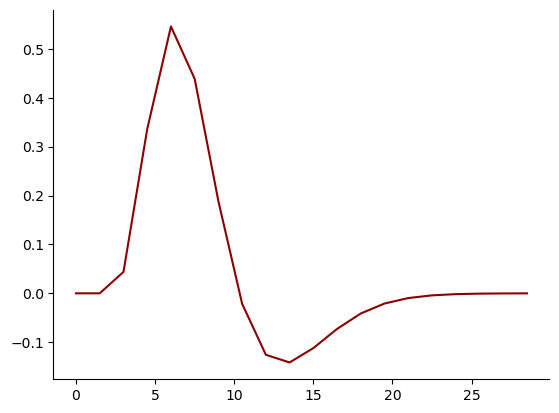

In [17]:
# Plot hemodynamic response function (HRF)
from nilearn.glm.first_level import glover_hrf
hrf = glover_hrf(tr, oversampling=1, time_length=30)

plt.plot(np.arange(0, 30, 1.5), hrf, c='darkred')
sns.despine()

Next, we'll convolve this HRF with the actual time series (I'll provde the code for this to avoid any confusion). You can think of this [convolution](https://en.wikipedia.org/wiki/Convolution) operation as effectively sliding the two time series alongside each other and summing the products of their overlap. Use `plt.plot` to visualize the two time series after convolution with an HRF.

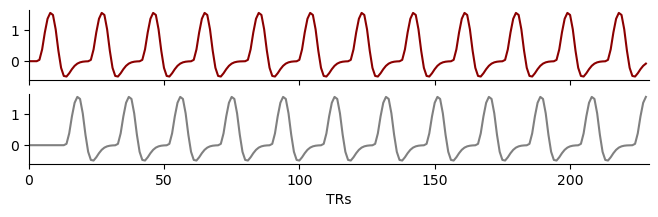

In [18]:
# Convolve boxcars with HRF and plot
language_regressor = np.convolve(language_events, hrf)[:n_trs]
control_regressor = np.convolve(control_events, hrf)[:n_trs]

# Plot time series after convolution with HRF:
fig, axs = plt.subplots(2, 1, figsize=(8, 2),
                        sharex=True, sharey=True)
axs[0].plot(language_regressor, c='darkred')
axs[1].plot(control_regressor, c='.5')
axs[1].set(xlabel='TRs', xlim=(0, n_trs))
sns.despine()

Our model is almost ready. Lastly, we'll stack these two time series as columns in a matrix alongside a column of $1$s to serve as the intercept. We'll call this our design matrix `X`. Use `matshow` or `imshow` to plot the design matrix with a grayscale colormap (e.g., `binary_r`). (If you use `matshow`, you may want to use, e.g., `np.repeat` to artificially widen the matrix for visualization.

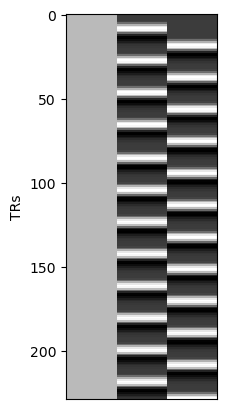

In [19]:
# Create design matrix
X = np.column_stack((np.ones(n_trs),
                     language_regressor,
                     control_regressor))

# Plot the design matrix:
fig, ax = plt.subplots(figsize=(2.5, 5))
ax.matshow(np.repeat(X, 30, axis=1), cmap='binary_r')
ax.set(xticks=[], ylabel='TRs');

Confirm (using `assert`) that the number of time points (i.e., TRs) in both $X$ and $Y$ match.

In [20]:
# Confirm that number of TRs in X and Y match:
assert X.shape[0] == Y.shape[0]

#### Running the regression model
We're finally ready to run our regression. We'll use multiple linear regression (often referred to as a general linear model or "GLM" in the fMRI literature; [Friston et al., 1994](https://doi.org/10.1002/hbm.460020402)) to quantify how much a given voxel responds to (i.e., is predicted by) the regressor for a given experimental condition. Here our model only has two regressors corresponding to the language task (meaningful sentences) and the control task (meaningless strings). We'll use `lstsq` from `np.linalg` to run ordinary least-squares (OLS) regression and extract the regression coefficient `b` (or "beta") from the output.

In [21]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)

This is a "mass univariate analysis" in the sense that we are effectively computing a separate regression model independently for each of $\approx20\text{,}000$ voxels (even when we solve the regression equation simultaneously across all voxels using matrix algebra; you could confirm this by running the regression separately on each voxel in a loop). Make sure you understand the shape of the `b` coefficients.

In [22]:
# Inspect the shape of the beta coefficients:
print(b.shape)

(3, 20657)


Typically we don't want to just look at the coefficient for the `language` task in isolation—we want to directly compare the `language` task (meaningful sentences) to the `control` task (meaningless strings). Compute a "contrast" (i.e., the difference) between the language and control coefficients (ignore the intercept coefficient).

In [23]:
# Compute contrast between language and control condition:
contrast = b[1] - b[2]

To convert this contrast values for the masked voxels back into a full 3-dimensional brain image, we can use the `.inverse_transform` method of our `masker` object. Plot the resulting contrast map `plot_glass_brain` from `nilearn.plotting` with `display_mode='lzr'`, `cmap='RdBu_r'`, `symmetric_cbar=True`, and `plot_abs=False`.

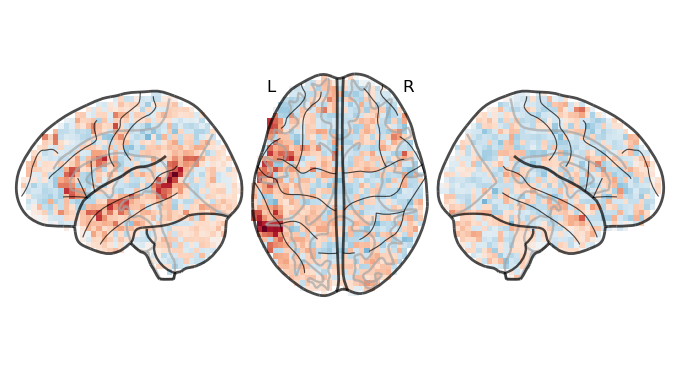

In [24]:
# Use masker to convert contrasts back into 3D brain image:
contrast_img = masker.inverse_transform(contrast)

# Plot contrast map:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(contrast_img, display_mode='lzr', cmap='RdBu_r',
                 symmetric_cbar=True, plot_abs=False, colorbar=False);

Use the Markdown cell below to write out a brief reflection (a couple sentences) interpreting what you can learn from this brain image. Consider the following points in your response:

* What exactly can we conclude from this contrast between meaningful sentences and sequences of meaningless consonant strings? What other tasks or contrasts might be useful in isolating language areas?

* Try re-running the above cells for, e.g., `sub-02` and look the resulting contrast map. What do you observe?

#### Reflection
*Your response here!*

*Bonus:* If you want to get even more into the nuts-and-bolts of linear algebra, try re-running the ordinary least-squares (OLS) regression using only [matrix algebra](https://en.wikipedia.org/wiki/Ordinary_least_squares#Matrix/vector_formulation) instead of `np.linalg.lstsq`. Define a function the `X` and `Y` as input and returns `b` according to the following equation: $\hat{\beta} = (X^{\top} X)^{-1} X^{\top} Y$. (You can use `@` for matrix multiplication and `np.linalg.inv` to compute the inverse of a matrix.) Check that your new matrix of coefficients is effectively equal to the previous `b` (e.g., using `np.allclose`).

In [25]:
# Bonus: compute weights using matrix algebra:
def ols_weights(X, Y):
    b = np.linalg.inv(X.T @ X) @ X.T @ Y
    return b

b_algebra = ols_weights(X, Y)

assert np.allclose(b, b_algebra)

### Part 2: Language localizer "at scale"
In this section, we'll move a bit closer to a production-level analysis across all $N = 10$ subjects. We'll take advantage of some higher-level *Nilearn* functions and leverage the fact that this dataset is organized according to the Brain Imaging Data Structure (BIDS; [Gorgolewsky et al., 2016](https://doi.org/10.1038/sdata.2016.44)). First, we'll use `first_level_from_bids` from `nilearn.glm.first_level` to automagically initialize subject-level regression models alongside the BOLD files, events tables, and confounds time series. Have a look at each of these lists to make sure you understand what we're working with. Note that we'll also apply some spatial smoothing in this analysis (`smoothing_fwhm=6`) to boost functional correspondence across individual subjects (at the expense of individual functional–anatomical specificity). *Nilearn* will also include the head motion time series from `confounds` as nuisance regressors in the GLM to minimize the effects of head motion.

In [26]:
# Extract all components of dataset based on BIDS
# (ignore warnings about StartTime and slice timing)
from nilearn.glm.first_level import first_level_from_bids

N = 10
task = 'languagelocalizer'
smoothing_fwhm = 8

model_list, bold_list, events_list, confounds_list = first_level_from_bids(
    dataset.data_dir,
    task,
    img_filters=[('desc', 'preproc')],
    space_label='',
    mask_img=mni_mask_r,
    smoothing_fwhm=smoothing_fwhm,
    n_jobs=2,
)

/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_47757/3739155242.py:9: RuntimeWarning: 'StartTime' not found in file /Users/snastase/Work/psyc599/nilearn-data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json.
  model_list, bold_list, events_list, confounds_list = first_level_from_bids(
/var/folders/ch/f_vp72713hg84pcp6t_2wfmw0000gp/T/ipykernel_47757/3739155242.py:9: UserWarning: 'slice_time_ref' not provided and cannot be inferred from metadata.
It will be assumed that the slice timing reference is 0.0 percent of the repetition time.
If it is not the case it will need to be set manually in the generated list of models.
  model_list, bold_list, events_list, confounds_list = first_level_from_bids(


Now that we've compiled all the necessary ingredients, we'll loop through each subject, fit their GLM, and compute the contrasts. This is basically the same thing we did in Part 1, but all at once (with a few additional bells and whistles). This cell may take a couple minutes to run: you're fitting $10$ (subjects) $\times$ $20\text{,}000$ (voxels) regression models! (in addition to all the masking, smoothing, detrending, etc)

In [27]:
# Zip all components together for loop
inputs = zip(model_list, bold_list, events_list, confounds_list)

# Loop through each subject and run regression model
models, contrasts = [], []
for n, (model, bold_f, events, confounds) in enumerate(inputs):
    model.fit(bold_f, events, confounds)
    contrast = model.compute_contrast("language-string")
    models.append(model)
    contrasts.append(contrast)
    print(f"Finished first-level model for subject {n + 1}")

Finished first-level model for subject 1
Finished first-level model for subject 2
Finished first-level model for subject 3
Finished first-level model for subject 4
Finished first-level model for subject 5
Finished first-level model for subject 6
Finished first-level model for subject 7
Finished first-level model for subject 8
Finished first-level model for subject 9
Finished first-level model for subject 10


Have a look at one of the fitted models. In the *Parameters* drop-down, you can see all of the defaults in *Nilearn*'s regression model. For example: we're using the `glover` HRF we used above; we're using cosine bases to account for slow drifts; we're using a high-pass filter with a cutoff at $0.01~\mathrm{Hz}$; we're using an AR(1) autoregressive model for regression.

In [28]:
# Inspect one of the fitted models:
models[0]

,t_r,1.5
,slice_time_ref,0.0
,hrf_model,'glover'
,drift_model,'cosine'
,high_pass,0.01
,drift_order,1
,fir_delays,None
,min_onset,-24
,mask_img,<nibabel.nift...t 0x1618d7450>
,target_affine,None
,target_shape,None


Let's visualize the data for all subjects at once. Using `plt.subplots` with a through the figure axes and contrast maps, you should be able to create a $2 \times 10$ grid of `plot_glass_brain` plots for the $N=10$ subjects. Specify `axes=ax` and `display_mode='l'` in your `plot_glass_brain` call, and remember to set `plot_abs=False` and `color_bar=False`. You can use the `n` variable to set the `title` of each subplot to the subject number.

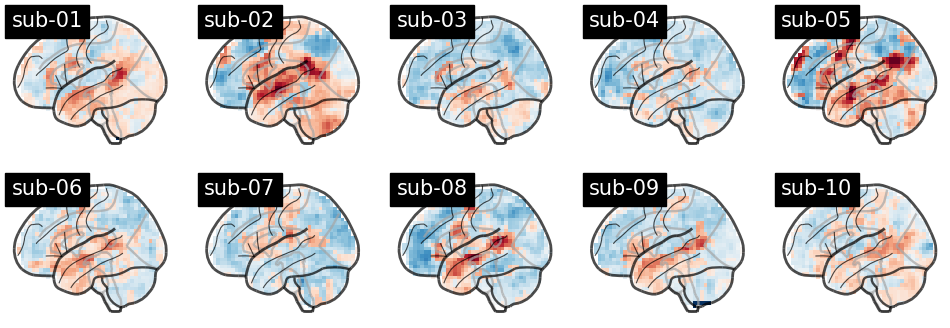

In [29]:
# Plot a montage of all subject-level contrast maps
fig, axs = plt.subplots(2, 5, figsize=(12, 4))
for n, (ax, contrast) in enumerate(zip(axs.ravel(), contrasts)):

    # Set up plot_glass_brain inside loop here:
    plot_glass_brain(contrast, axes=ax, plot_abs=False, colorbar=False,
                     title=f'sub-{n + 1:02d}', display_mode='l',
                     cmap='RdBu_r', vmin=-10, vmax=10)

How can we evaluate the strength of this contrast across subjects? The most straightforward approach to statistically assess a group-level effect would be to perform a one-sample *t*-test across the subject-level contrast maps. Note that this is mathematically equivalent to performing a paired *t*-test for the difference between the language and control coefficients. First, use `vstack` and `masker.transform` to create a two-dimensional stack of contrast maps where axis 0 corresponds to the $N = 10$ subjects and axis 1 corresponds to the voxels in the mask. Next, using `np.mean`, compute the mean contrast across subjects and hold onto it for later. Finally, you can use `ttest_1samp` from `scipy.stats` to perform a two-sided t-test against the population mean of zero contrast. This should yield a set of *t*- and *p*-values for each voxel.

In [30]:
# Stack masked contrast maps across subjects:
contrast_stack = np.vstack([masker.transform(c) for c in contrasts])

# Compute the mean across subjects:
contrast_mean = np.mean(contrast_stack, axis=0)

# Use ttest_1samp to compute t- and p-values:
from scipy.stats import ttest_1samp

t, p = ttest_1samp(contrast_stack, popmean=0, axis=0, alternative='two-sided')

To decide which voxels show a statistically significant effect, we can't just threshold this map at $p < .05$. For $\sim20\text{,}000$ voxels, we would expect to see $\sim1\text{,}000$ significant just by chance (yikes). There are variety of ways to control for multiple tests (e.g., [Eklund et al., 2016](https://doi.org/10.1073/pnas.1602413113)), but here we'll simply control the false discovery rate (FDR; [Benjamini & Hochberg, 1995](https://doi.org/10.1111/j.2517-6161.1995.tb02031.x)) at $.05$. Use `multipletests` from `statsmodels.stats.multitest` with `method='fdr_bh'` to identify which voxels remain significant when controlling FDR at $.05$. Call this mask of FDR-significant voxels `reject` (i.e., "rejecting" the null hypothesis).

In [31]:
# Identify significant voxels when controlling FDR:
from statsmodels.stats.multitest import multipletests

reject, q, _, _ = multipletests(p, alpha=0.05, method='fdr_bh')

Given a mask of significant voxels (called `reject`), we can construct a final result map. We'll start with a map of zeros and insert the mean contrast value for the voxels where the effect is significant at $p_\mathrm{FDR} < .05$. Then, we'll use `masker.inverse_transform` to convert these voxels back into a 3-dimensional image.

In [32]:
# Create result map thresholded by FDR
result = np.zeros(t.shape)
result[reject] = contrast_mean[reject]

# Transform masked voxels back into 3D image
result_img = masker.inverse_transform(result)

Plot the `result_img` using `plot_glass_brain` with `display_mode='lzr'`, `cmap='RdBu_r'`, `symmetric_cbar=True`, `plot_abs=False`, and `threshold=0`. 

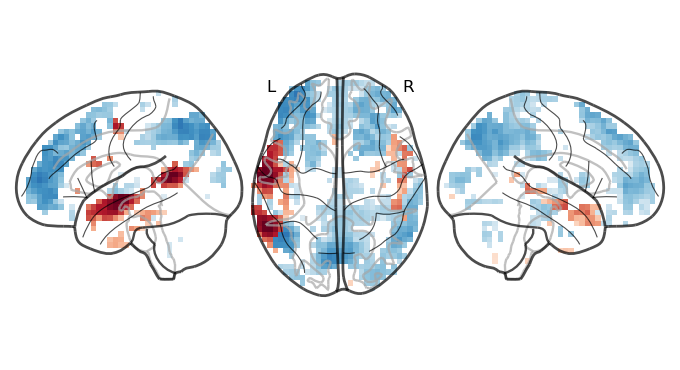

In [33]:
# Plot the FDR-thresholded brain image:
plot_glass_brain(result_img, plot_abs=False,  symmetric_cbar=True,
                 display_mode='lzr', cmap='RdBu_r', colorbar=False,
                 threshold=0, vmin=-4.5, vmax=4.5);

We can achieve the same effect a bit more succintly using *Nilearn*. First, we set up a group-level analysis using `SecondLevelModel` based on the same contrast we used in the subject-level analysis. Using `.compute_contrast`, we can ask for *z*-scores, *t*-values, *p*-values, and the effect sizes (coefficients).

In [34]:
from nilearn.glm.second_level import SecondLevelModel

# Compile first-level models as input to group analysis
group_input = models

# Initialize and fit group-level model
group_model = SecondLevelModel(n_jobs=2)
group_model = group_model.fit(group_input)

# Compute contrasts and extract statistics
results = group_model.compute_contrast(
    first_level_contrast='language-string',
    second_level_stat_type='t', output_type='all')
results

{'z_score': <nibabel.nifti1.Nifti1Image at 0x30426e7b0>,
 'stat': <nibabel.nifti1.Nifti1Image at 0x30426e8d0>,
 'p_value': <nibabel.nifti1.Nifti1Image at 0x30426e720>,
 'effect_size': <nibabel.nifti1.Nifti1Image at 0x30426ee70>,
 'effect_variance': <nibabel.nifti1.Nifti1Image at 0x30426ede0>}

Next, we can use `threshold_stats_img` to obtain an FDR-corrected statistical threshold. We binarize this threshold and multiply it by the effect size map to replicate the same result from above. (Note that sometimes published papers will report thresholded effect size maps, but sometimes they will report thresholded *t*- or *z*-value maps.)

In [35]:
from nilearn.glm import threshold_stats_img
from nilearn.image import binarize_img, math_img

# Use FDR correction to identify statistically significant voxels
threshold_map, threshold = threshold_stats_img(
    results['z_score'], alpha=0.05, height_control='fdr',
    mask_img=mni_mask_r, two_sided=True)

# Use multiplication hack to threshold effect size image
result_img = math_img('img1 * img2',
                      img1=results['effect_size'],
                      img2=binarize_img(threshold_map, two_sided=True))

Finally, let's plot the resulting statistical map and compare it to the plot we created above by "manually" performing the t-test and FDR correction.

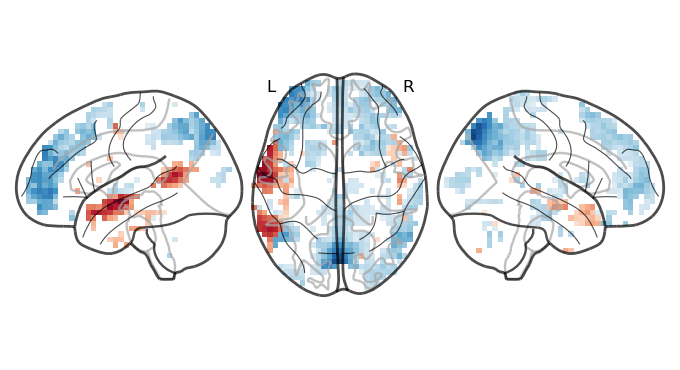

In [36]:
# Plot the FDR-thresholded brain image
plot_glass_brain(result_img, plot_abs=False,  symmetric_cbar=True,
                 display_mode='lzr', cmap='RdBu_r', colorbar=False,
                 threshold=0);

Write a brief reflection (a couple sentences) about what you learned from these analyses. Consider the following points in your response:

* Do these results match with what you would expect from the literature you've read so far?

* Observe the variability in effect sizes and cortical topography across individual subjects. How can we better accommodate these individual differences in functional topography?

* How do you interpret the "significantly" negative activations (blue) in posterior medial areas (e.g., precuneus) and anterior prefrontal areas?

#### Reflection
*Your response here!*

### References
* Abraham, A., Pedregosa, F., Eickenberg, M., Gervais, P., Mueller, A., Kossaifi, J., Gramfort, A., Thirion, B., & Varoquaux, G. (2014). Machine learning for neuroimaging with scikit-learn. *Frontiers in Neuroinformatics*, *8*, 14. https://doi.org/10.3389/fninf.2014.00014

* Benjamini, Y., & Hochberg, Y. (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. *Journal of the Royal Statistical Society: Series B (Methodological)*, *57*(1), 289–300. https://doi.org/10.1111/j.2517-6161.1995.tb02031.x

* Eklund, A., Nichols, T. E., & Knutsson, H. (2016). Cluster failure: why fMRI inferences for spatial extent have inflated false-positive rates. *Proceedings of the National Academy of Sciences*, *113*(28), 7900–7905. https://doi.org/10.1073/pnas.1602413113

* Fedorenko, E., Hsieh, P. J., Nieto-Castañón, A., Whitfield-Gabrieli, S., & Kanwisher, N. (2010). New method for fMRI investigations of language: defining ROIs functionally in individual subjects. *Journal of Neurophysiology*, *104*(2), 1177–1194. https://doi.org/10.1152/jn.00032.2010

* Fedorenko, E., Ivanova, A. A., & Regev, T. I. (2024). The language network as a natural kind within the broader landscape of the human brain. *Nature Reviews Neuroscience*, *25*(5), 289–312. https://doi.org/10.1038/s41583-024-00802-4

* Friston, K. J., Holmes, A. P., Worsley, K. J., Poline, J. P., Frith, C. D., & Frackowiak, R. S. (1994). Statistical parametric maps in functional imaging: a general linear approach. *Human Brain Mapping*, *2*(4), 189–210. https://doi.org/10.1002/hbm.460020402

* Glover, G. H. (1999). Deconvolution of impulse response in event-related BOLD fMRI. *NeuroImage*, *9*(4), 416–429. https://doi.org/10.1006/nimg.1998.0419

* Gorgolewski, K. J., Auer, T., Calhoun, V. D., Craddock, R. C., Das, S., Duff, E. P., ... & Poldrack, R. A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. *Scientific Data*, *3*, 160044. https://doi.org/10.1038/sdata.2016.44

* Pallier, C. (2019). fMRI language localizer demo dataset. *OSF*. https://osf.io/k4jp8